In [3]:
from jax.config import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import grad, jit, jacobian, vmap
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.optimize as so
import scipy.integrate as si
import matplotlib.pyplot as plt

In [ ]:
@njit
def toeplitz(r, c):
    c = np.asarray(c).ravel()
    r = np.asarray(r).ravel()
    # Form a 1-D array containing a reversed c followed by r[1:]
    # that can be strided to give us toeplitz matrix.
    vals = np.concatenate((c[::-1], r[1:]))
    out_shp = len(c), len(r)
    n = vals.strides[0]
    return np.lib.stride_tricks.as_strided(vals[len(c)-1:], shape=out_shp, strides=(-n, n)).copy()

In [5]:
# set up computational parameters (such as computational region)

# set radius of spatial domain
l = 16

# set real space grid, used for plotting
# this has to be even for the comparison of
# of methods for converting the true potential to
# the Fourier basis to work.
nx = 1025

# real space spatial grid for the purposes of plotting
# dx is needed to perform norm check of training data
xvec, dx = np.linspace(-l, l, nx, retstep=True)

# set number of Fourier basis from n = -nF to n = nF
nF = 256

# matrix for converting Fourier basis coefficients into real space
# wave functions by matrix multiplication
nvec = np.arange(-nF, nF+1) # nvec=-nfb,...,0,...,nfb
Fmat = (1 / np.sqrt(2 * l)) * np.exp(1j * np.pi * np.outer(nvec, xvec) / l)

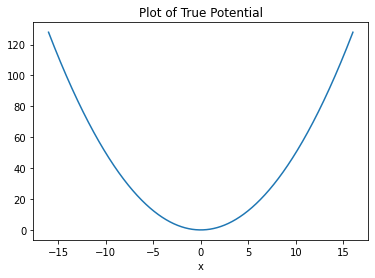

In [51]:
# define potential used to evolve the system

def v(x):
    # dimensionless quantum harmonic oscillator potential
    # return 0.5 * x**2
    # symmetric double well potential
    return 0.25 * (x**2 - 25)**2
    # rescaled symmetric double well potential
    # return 0.0025 * (x**2 - 25)**2
    # scaled asymmetric double well potential
    # return 0.0003*((x-3)**4 + 10*(x-5)**3)
    # soft coulomb potential
    # return -1 / np.sqrt(x**2 + 0.25)

# compute true potential at xvec real space grid points
vtruvec = v(xvec)

# plot true potential
plt.plot(xvec, vtruvec)
plt.title('Plot of True Potential')
plt.xlabel('x')
plt.show()

(257,)
(257, 1024)
(257,)


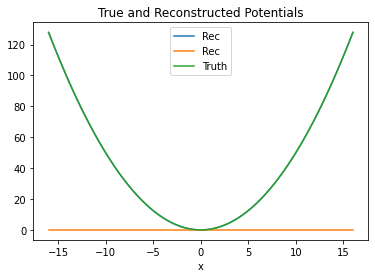

Rel Norm Diff of Rec (should be close to zero):
0.0003632383179096245


In [98]:
# transform true potential to Fourier basis

# Fres can be adjusted to improve the Fourier basis resolution
# if we set Fres = 1, then Fsample = 2*nfb, which is the
# Nyquist frequency (which is low quality?)
# Fres = 100
# Fsample = Fres * 2 * nF
# print(Fsample)
# Fxvec = np.linspace(-l, l, Fsample + 2)
# Fvvec = np.fft.rfft(v(Fxvec), norm='forward')
# print(Fvvec.shape)
# print(Fmat.shape)
# Fvvecrec = np.fft.irfft(Fvvec, norm='forward')
# print(Fvvecrec.shape)

# compute Fourier basis representation of potential
# using a quadrature method
# FFT method gives reconstructions with a RND on the
# order of 1e-16, while the quadrature method is on
# order of 1e-4, so the FFT is more accurate
def vintegrand(x):
    return v(x) * np.exp(-1j * np.pi * nvec * x / l) / np.sqrt(2 * l)
# vquadrtn = si.quad_vec(vintegrand, -l, l)[0]
# print(vquadrtn.shape)
print(Fmat.shape)
# Fvtruvecrec2 = vquadrtn @ Fmat
Fvvec = si.quad_vec(vintegrand, -l, l)[0]
Fvvecrec = Fvvec @ Fmat
print(Fvvec.shape)

# plot potentials
# plt.plot(Fxvec, Fvtruvecrec1, '-', label='FFT')
# plt.plot(xvec, Fvtruvecrec2.real, '-', label='quad real')
# plt.plot(xvec, Fvtruvecrec2.imag, '-', label='quad imag')
# plt.plot(xvec, vtruvec, label='Truth')
# plt.title('True and Reconstructed Fourier Basis Potentials')
# plt.xlabel('x')
# plt.legend()
# plt.show()

# print('Rel Norm Diff FFT:', nl.norm(vtruvec - Fvtruvecrec1) / nl.norm(vtruvec))
# print('Rel Norm Diff quad:', nl.norm(vtruvec - Fvtruvecrec2) / nl.norm(vtruvec))

# plot potentials
plt.plot(xvec, Fvvecrec.real, '-', label='Rec')
plt.plot(xvec, Fvvecrec.imag, '-', label='Rec')
plt.plot(xvec, vtruvec, label='Truth')
plt.title('True and Reconstructed Potentials')
plt.xlabel('x')
plt.legend()
plt.show()

print('Rel Norm Diff of Rec (should be close to zero):', nl.norm(vtruvec - Fvvecrec) / nl.norm(vtruvec), sep='\n')

(257,)
(257, 1024)


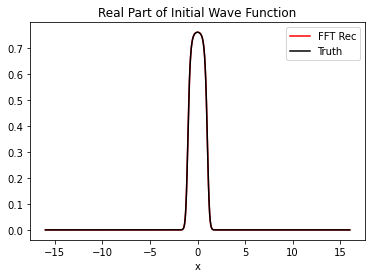

Rel Norm Diff FFT: 5.020490226204405e-05


In [99]:
# define initial state and transform to Fourier basis

def psi0(x):
    # rounded box function
    return 1.0 + np.tanh((1 - x**2)/0.5)
    # triangular pulse
    # return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - np.abs(x)), 0])
    # parabolic pulse
    # return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - x**2), 0])
    # hyperbolic secant squared
    # return (np.cosh(x))**(-2)
    # Laplace
    # return np.exp(-np.abs(x))

def mknormpsifn(psifn):
    # compute psi normalization term,
    # this is a constant given some psi
    psiprobintegrand = lambda x: np.abs(psifn(x))**2
    normterm = np.sqrt(si.quad(psiprobintegrand, a=-l, b=l)[0])

    # define function for computing normalized psi
    # via scipy.integrate methods
    def normpsifn(x):
        return psifn(x)/normterm

    return normpsifn

normpsi0fn = mknormpsifn(psi0)

# vector of the normalized psi0 function sampled on the
# real space grid, "Truth"
normpsi0truvec = normpsi0fn(xvec)

# compute the Fourier basis representation of the
# normalized psi0 function using FFT method
# Fnormpsi0vec = np.fft.fft(normpsi0truvec, norm='forward')
# Fnormpsi0vecrec = np.fft.ifft(Fnormpsi0vec, norm='forward')
# Fnormpsi0vecrec1 = np.fft.ifft(Fnormpsi0vec, norm='forward')

# compute the Fourier basis representation of the
# normalized psi0 function using a scipy.integrate method
# this method produced a reconstruction who's relative
# norm difference ranged from 1e-2 to 1e-11.
# The FFT method on the other hand was always of the
# order 1e-16, so that is the method I will use
normpsi0integrand = lambda x: np.exp(-1j * np.pi * nvec * x / l) / np.sqrt(2 * l) * normpsi0fn(x)
normpsi0quadrtn = si.quad_vec(normpsi0integrand, -l, l)[0]
Fnormpsi0vec = si.quad_vec(normpsi0integrand, -l, l)[0]
print(normpsi0quadrtn.shape)
print(Fmat.shape)
# Fnormpsi0vecrec2 = normpsi0quadrtn @ Fmat
Fnormpsi0vecrec = normpsi0quadrtn @ Fmat

# plot the real port of the normalized psi0
# plt.plot(xvec, Fnormpsi0vecrec1.real, 'r', label="Quad Rec")
# plt.plot(xvec, Fnormpsi0vecrec2.real, 'b', label="FFT Rec")
# plt.plot(xvec, normpsi0truvec.real, 'k', label="Truth")
# plt.title('Real Part of Initial Wave Function')
# plt.xlabel('x')
# plt.legend()
# plt.show()

# print('Rel Norm Diff FFT:', nl.norm(normpsi0truvec - Fnormpsi0vecrec1) / nl.norm(normpsi0truvec))
# print('Rel Norm Diff quad:', nl.norm(normpsi0truvec - Fnormpsi0vecrec2) / nl.norm(normpsi0truvec))

# plot the real part of the normalized psi0
plt.plot(xvec, Fnormpsi0vecrec.real, 'r', label="Rec")
plt.plot(xvec, normpsi0truvec.real, 'k', label="Truth")
plt.title('Real Part of Initial Wave Function')
plt.xlabel('x')
plt.legend()
plt.show()

print('Rel Norm Diff FFT:', nl.norm(normpsi0truvec - Fnormpsi0vecrec) / nl.norm(normpsi0truvec))

hmat is Hermitian? (should be close to zero):
2.255369337203809e-14
Does the eigen-decomposition diagonalizes hmat (should be close to zero):
 1.3136784253815512e-11
stts unitary? (should be close to zero):
3.6667960194805406e-14
(201,)


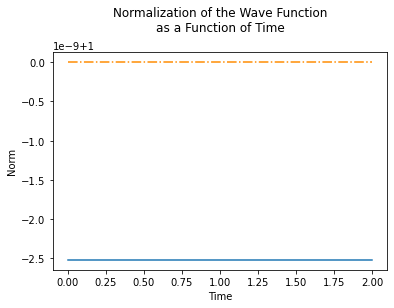

Average Norm of Trajectory (should be close to 1):
0.999999997479787


In [101]:
# solve the forward problem and generate amat

# set the size of a time step
dt = 0.01

# set the number of time steps to take starting from
# the initial state (a single trajectory should be
# nts + 1 states, this includes the initial state)
nts = 200

# construct the kinetic operator matrix representation
# in the Fourier basis (this is constant for a given system)
kmat = np.diag(np.arange(-nF, nF+1) ** 2 * np.pi ** 2 / (2 * l ** 2))

# set the number of elements to be stored for the Toeplitz
# representation of the potential operator in the Fourier
# basis representation (this is a method of dimensionality
# reduction)
ntoe = 2 * nF + 1

# construct the potential operator matrix representation
# in the Fourier basis (this depends on the potential function)
toeFvvec = Fvvec[:ntoe] * (-1) ** np.arange(ntoe)
vmat = toeplitz(toeFvvec, toeFvvec.conj())

# construct the Hamiltonian operator matrix representation
# in the Fourier basis
hmat = kmat + vmat
# check hmat is Hermitian
print('hmat is Hermitian? (should be close to zero):', nl.norm(hmat - hmat.T.conj()), sep='\n')

# perform an eigen-decomposition of hmat
spc, stts = np.linalg.eigh(hmat)
# check that the eigen-decomposition diagonalizes hmat
# if this is close to zero then
# hmat = states @ np.diag(spec) @ np.conj(states).T
print('Does the eigen-decomposition diagonalizes hmat (should be close to zero):\n', nl.norm(hmat @ stts - stts @ np.diag(spc)))

# check that the eigenstates are unitary
print('stts unitary? (should be close to zero):', nl.norm(stts @ stts.conj().T - np.eye(ntoe)), sep='\n')

# make the matrix for propagating the "a" state vector
propamat = stts @ np.diag(np.exp(-1j * spc * dt)) @ np.conj(stts.T)

# propagate the system starting from the initial "a" state
amat = np.zeros((nts + 1, ntoe), dtype=np.complex128)
# amat[0,:] = np.copy(Fnormpsi0vec[:ntoe])
amat[0,:] = np.copy(Fnormpsi0vec)
for i in range(nts):
    amat[i+1,:] = propamat @ amat[i,:]

# convert amat to a matrix of real space wave functions
psimat = amat @ Fmat

# check that each wave function is normalized to 1
# this should produce a graph with a line that is almost
# completely horizontal at 1
psimatnormvec = si.trapezoid(np.abs(psimat) ** 2, xvec, axis=1)
# psimatnormvec = np.sum(np.abs(psimat)**2, axis=1) * dx
print(psimatnormvec.shape)
plt.plot(np.arange(nts + 1) * dt, psimatnormvec)
plt.hlines(1 , 0, nts * dt, linestyles='-.', colors='darkorange')
plt.title('Normalization of the Wave Function\nas a Function of Time\n')
plt.xlabel('Time')
plt.ylabel('Norm')
plt.show()
# norm difference of wave function normalization check,
# this should be close to 1
print('Average Norm of Trajectory (should be close to 1):', psimatnormvec.sum() / (nts + 1), sep='\n')

In [ ]:
# store computed amat to disk